In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # number of batches
# 68 * 32 = 2176
# this is bigger than total number of images, 
# since the last batch has less than 32 images.

68

(32, 256, 256, 3)
(256, 256, 3)
[1 1 0 1 0 1 1 0 0 2 1 0 1 1 0 0 1 0 1 0 0 2 1 1 1 0 1 1 1 0 0 1]


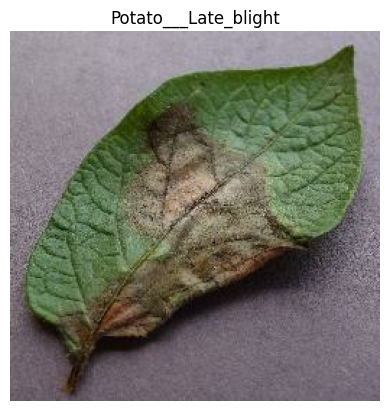

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch[0].shape)
    print(label_batch.numpy())

    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

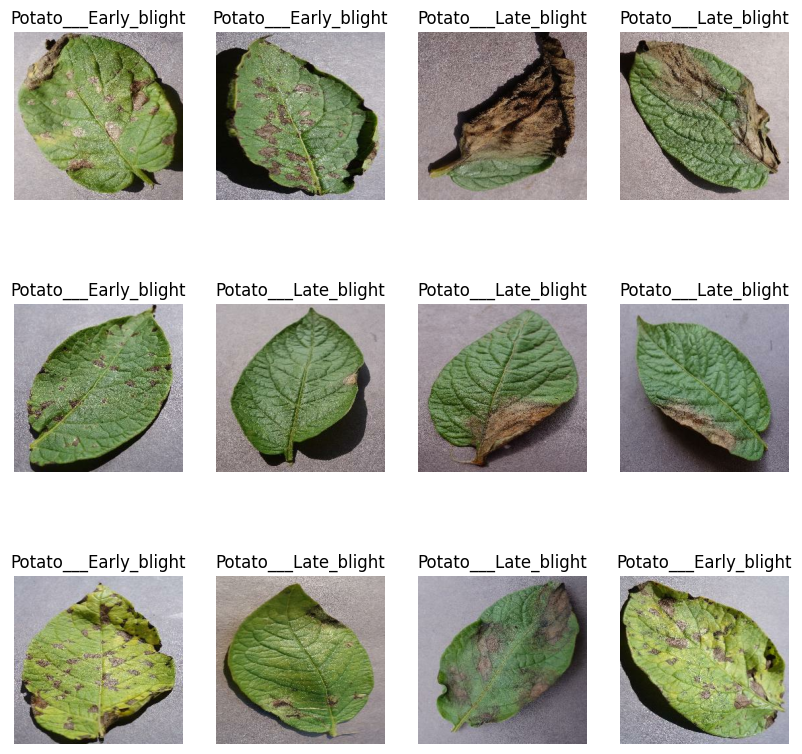

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [10]:
train_size = 0.8
train_ds = dataset.take(int(train_size*len(dataset)))
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    trains_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# this block of code optimises the program by caching.

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
# preprocessing every time so that slight variations while computing wont occur

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# to make our model robust and immune to small variations on real life samples

In [22]:
 # -----------------------Building CNN model for our project (Video - 2)---------------------------------------------

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
# 32 layers is just found out by trial and error
# 6 layers is due to trial and error

# relu is a popular activation layer, because is very fast to compute


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


54/54 [==============================] - 33s 328ms/step - loss: 0.9123 - accuracy: 0.4844 - val_loss: 0.8237 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 11s 197ms/step - loss: 0.7284 - accuracy: 0.6545 - val_loss: 0.5158 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 8s 155ms/step - loss: 0.4666 - accuracy: 0.7946 - val_loss: 0.4443 - val_accuracy: 0.7976
Epoch 4/50
54/54 [==============================] - 8s 148ms/step - loss: 0.3342 - accuracy: 0.8652 - val_loss: 0.3074 - val_accuracy: 0.8690
Epoch 5/50
54/54 [==============================] - 9s 158ms/step - loss: 0.2755 - accuracy: 0.8912 - val_loss: 0.2680 - val_accuracy: 0.8929
Epoch 6/50
54/54 [==============================] - 8s 157ms/step - loss: 0.2338 - accuracy: 0.9045 - val_loss: 0.3003 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 9s 161ms/step - loss: 0.2389 - accuracy: 0.9057 - val_loss: 0.1707 - val_accuracy: 0.9345
Epoch 8/50
25/5

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2762407534464749254
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2236245607
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 587015591773316461
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 70ms/step - loss: 0.0108 - accuracy: 0.9961


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.49363425374031067,
 0.6776620149612427,
 0.8026620149612427,
 0.8738425970077515,
 0.8987268805503845,
 0.9577546119689941,
 0.96875,
 0.9502314925193787,
 0.9600694179534912,
 0.9751157164573669,
 0.9571759104728699,
 0.9658564925193787,
 0.9866898059844971,
 0.9809027910232544,
 0.9791666865348816,
 0.9606481194496155,
 0.9716435074806213,
 0.9907407164573669,
 0.9797453880310059,
 0.9866898059844971,
 0.9774305820465088,
 0.9837962985038757,
 0.9797453880310059,
 0.9855324029922485,
 0.9675925970077515,
 0.9774305820465088,
 0.9872685074806213,
 0.9890046119689941,
 0.9872685074806213,
 0.9681712985038757,
 0.9837962985038757,
 0.9820601940155029,
 0.9855324029922485,
 0.9837962985038757,
 0.9878472089767456,
 0.9918981194496155,
 0.9866898059844971,
 0.9895833134651184,
 0.9907407164573669,
 0.9866898059844971,
 0.9861111044883728,
 0.9942129850387573,
 0.9866898059844971,
 0.9953703880310059,
 0.9953703880310059,
 0.9976851940155029,
 0.9837962985038757,
 0.9901620149612427,
 0

Text(0.5, 1.0, 'Training and Validation Accuracy')

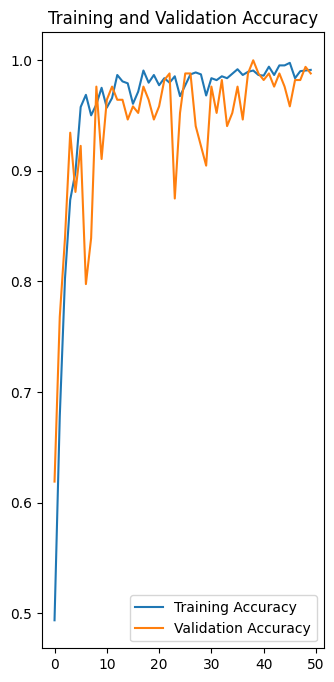

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
first image's actual label:  Potato___Early_blight
1/1 [==============================] - 0s 365ms/step
[9.9999976e-01 2.0910056e-07 3.7639387e-15]
predicted label: Potato___Early_blight


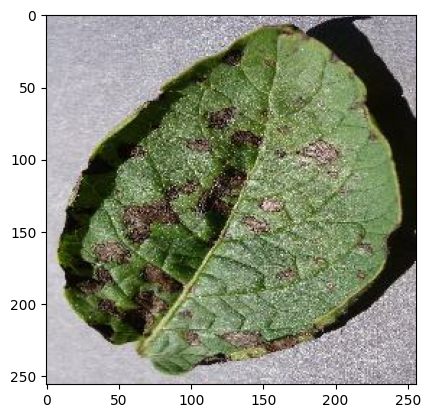

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


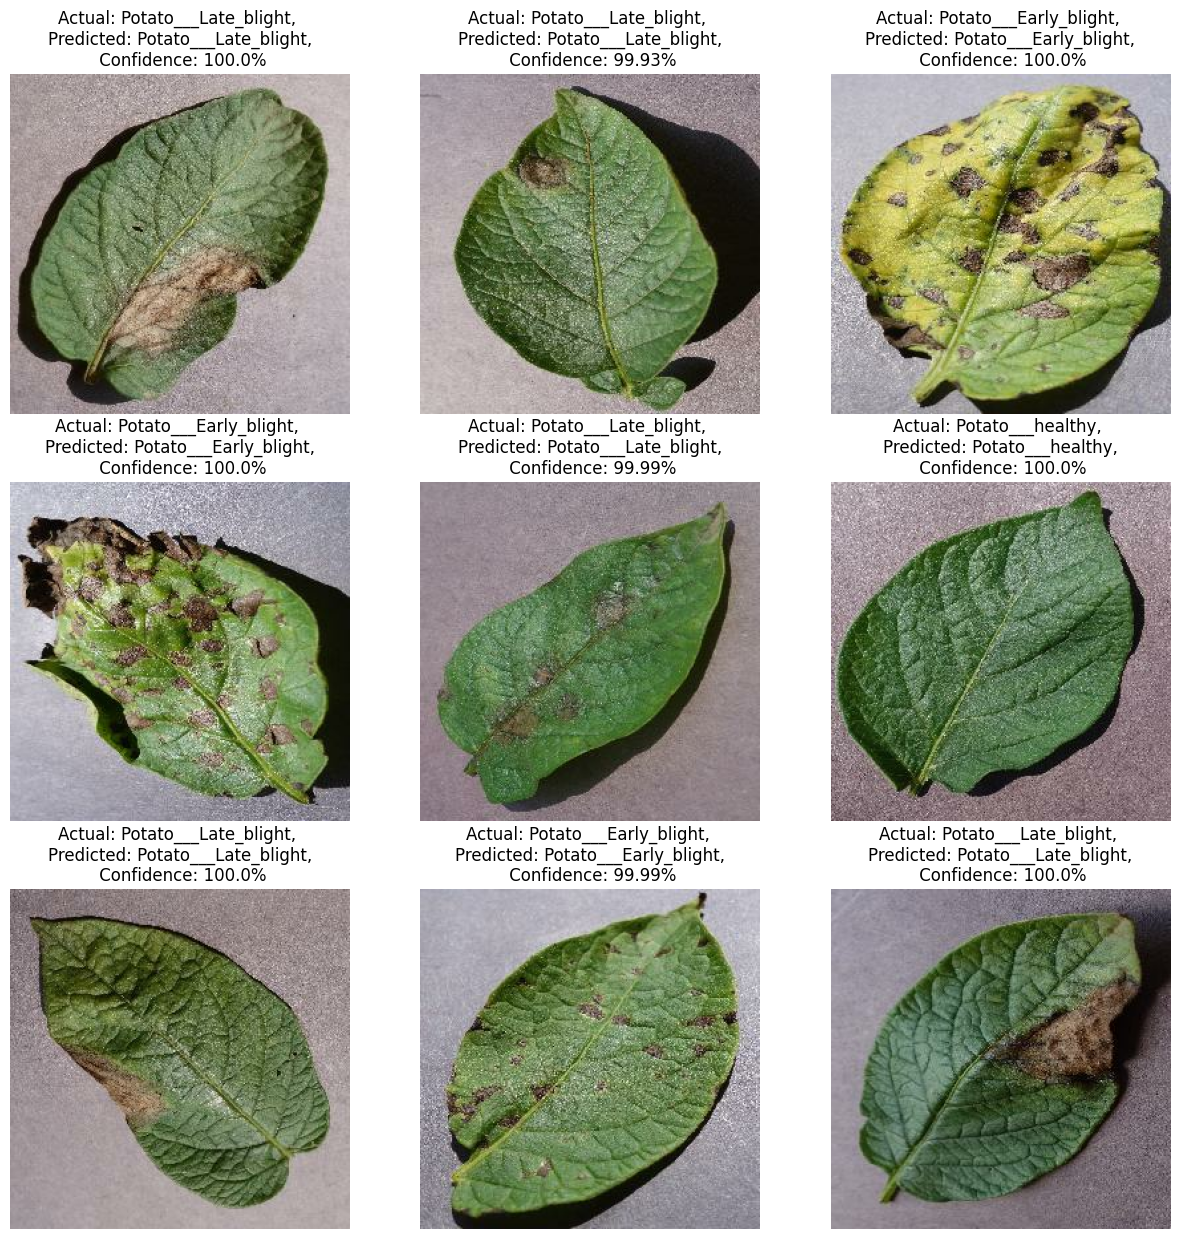

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/6\assets


INFO:tensorflow:Assets written to: ../saved_models/6\assets


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices() 

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7081963912567806370
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2236245607
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4081427296592866448
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from tqdm import tqdm

for i in tqdm(range(int(9e6))):
    pass

100%|██████████| 9000000/9000000 [00:01<00:00, 5438698.84it/s]
